# Subreddit Gender Ratios

This is a redux of my previous [analysis of subreddit gender ratios][gender] project. This time I have access to better data because [/u/Stuck_In_the_Matrix] has [downloaded every publicly available Reddit comment][dataset] and made them publicly available. Additionally, the dataset is now available in [Google BigQuery][bigquery] allowing easy analysis.

The dataset includes users' flair like the [Reddit flair API][api] I used previously. Notably, the new dataset also allows us to generate a list of all submitters in a subreddit, which was extremely difficult previously.

Basically we will be deriving the gender for as many users as possible from their flair in various subreddits. Then we will use that set of users as a random sample of every other subbreddit and guessing the gender ratio.

[/u/Stuck_In_the_Matrix]: https://www.reddit.com/user/Stuck_In_the_Matrix
[gender]: https://np.reddit.com/r/dataisbeautiful/comments/1wtnkd/subreddit_gender_ratios_oc/cf58xcr/
[bigquery]: https://bigquery.cloud.google.com/table/fh-bigquery:reddit_comments.2015_05
[dataset]: https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment/
[api]: https://www.reddit.com/dev/api/#section_flair

## Limitations

*  **We have no idea if the combined set of sampled users are representative of all Reddit users.** In fact, some subreddits in the results look over represented in the results because they share many users with one of the subreddits we used for deriving gender. We just use as many subreddits as we can for gender and hope it's good enough.

*  **The number of sampled users is very small compared to the set of all commenters of each subreddit.**

In my previous analysis, it was near impossible to get a list of all commenters or subscribers of a subreddit. Instead the list of users with flair in a given subreddit was used as a proxy. That had major issues because in many subreddits the commenters and set of flaired users are not always the same. For example, some subreddits only give flair to submitters, which biased the results significantly. With the new dataset of every Reddit comment, that is no longer an issue.

In otherwords, this analysis is only mostly terrible now instead of completely terrible. I really doubt the exact percentages calculated are correct, but the relative comparisons between them and rankings look plausible.

## BigQuery analysis

We will be doing almost all the analysis in BigQuery using SQL directly.

I'm using [Jupyter][Jupyter] and [IPython][IPython], so I'd like a nice interface to run BigQuery SQL statements. Let's quickly define `%%bigquery` as an IPython cell magic. 

This is pretty hacky, I'm using tons of internal functions from [pandas-gbq]. This is mostly a modified version of [run_query()][run_query] that limits the retrieved results to a specified number of rows. It doesn't really bother handle the data types of the results either. We also add SQL syntax highlighting in the Jupyter notebook for our new magic.

If you reuse this code, change `PROJECT_ID` to your own project ID from the Google Cloud Platform Console. You will also have to enable billing on the project and ensure BigQuery is enabled. You can follow the [quickstart][quickstart] in their documentation.

You can add the `--verbose` flag to the magic to get status updates as it runs.

[Jupyter]: https://jupyter.org/
[IPython]: https://ipython.org/
[pandas-gbq]: https://github.com/pydata/pandas-gbq
[run_query]: https://github.com/pydata/pandas-gbq/blob/4cab83cefb7df190bf3e5b43168c2cb53f596c31/pandas_gbq/gbq.py#L458
[quickstart]: https://cloud.google.com/bigquery/quickstart-web-ui

Becauase my `%%bigquery` code is horribly hacky, make sure you have the exact version of `pandas-gbq` that I used:

```
pip3 install -e git+https://github.com/pydata/pandas-gbq@4cab83cefb7df190bf3e5b43168c2cb53f596c31#egg=pandas-gbq
```

In [13]:
PROJECT_ID = 'bburky'

In [14]:
import pandas
from pandas_gbq import gbq
from IPython.core.magic import register_cell_magic
from IPython.core.magic_arguments import (
    argument, magic_arguments, parse_argstring)
from google.auth.exceptions import RefreshError
from google.cloud.bigquery import QueryJobConfig
from concurrent.futures import TimeoutError
import itertools


@register_cell_magic
@magic_arguments()
@argument('-d', '--dialect', default='standard',
          choices=['standard', 'legacy'])
@argument('--writedisposition', default='WRITE_EMPTY',
          choices=['WRITE_TRUNCATE', 'WRITE_APPEND', 'WRITE_EMPTY'])
@argument('-v', '--verbose', action='store_true')
@argument('--limit', type=int, default=0,
          help='Limit rows or retreived results to this number')
@argument('--destinationtable',
          help='Save query results to destination table')
def bigquery(line, cell):
    args = parse_argstring(bigquery, line)
    query = cell

    connector = gbq.GbqConnector(
        PROJECT_ID, reauth=False, verbose=args.verbose,
        dialect=args.dialect, auth_local_webserver=False)

    job_config = {
        'query': {
            'writeDisposition': args.writedisposition,
        }
    }

    if args.destinationtable:
        dataset_id, table_id = args.destinationtable.rsplit('.', 1)
        job_config['query']['destinationTable'] = {
            'projectId': PROJECT_ID,
            'datasetId': dataset_id,
            'tableId': table_id,
        }

    connector._start_timer()
    try:
        connector._print('Requesting query... ', end="")
        query_reply = connector.client.query(
            query,
            job_config=QueryJobConfig.from_api_repr(job_config['query']))
        connector._print('ok.')
    except (RefreshError, ValueError):
        if connector.private_key:
            raise gbq.AccessDenied(
                "The service account credentials are not valid")
        else:
            raise gbq.AccessDenied(
                "The credentials have been revoked or expired, "
                "please re-run the application to re-authorize")
    except connector.http_error as ex:
        connector.process_http_error(ex)

    job_id = query_reply.job_id
    connector._print('Job ID: %s\nQuery running...' % job_id)

    while query_reply.state != 'DONE':
        connector.print_elapsed_seconds('  Elapsed', 's. Waiting...')

        timeout_ms = job_config['query'].get('timeoutMs')
        if timeout_ms and timeout_ms < connector.get_elapsed_seconds() * 1000:
            raise QueryTimeout('Query timeout: {} ms'.format(timeout_ms))

        timeout_sec = 1.0
        if timeout_ms:
            # Wait at most 1 second so we can show progress bar
            timeout_sec = min(1.0, timeout_ms / 1000.0)

        try:
            query_reply.result(timeout=timeout_sec)
        except TimeoutError:
            # Use our own timeout logic
            pass
        except connector.http_error as ex:
            connector.process_http_error(ex)

    if connector.verbose:
        if query_reply.cache_hit:
            connector._print('Query done.\nCache hit.\n')
        else:
            bytes_processed = query_reply.total_bytes_processed or 0
            bytes_billed = query_reply.total_bytes_billed or 0
            connector._print('Query done.\nProcessed: {} Billed: {}'.format(
                connector.sizeof_fmt(bytes_processed),
                connector.sizeof_fmt(bytes_billed)))
            connector._print('Standard price: ${:,.2f} USD\n'.format(
                bytes_billed * connector.query_price_for_TB))

        connector._print('Retrieving results...')

    try:
        rows_iter = query_reply.result()
    except connector.http_error as ex:
        connector.process_http_error(ex)
    if args.limit:
        connector._print('  Limiting results to {} rows'.format(args.limit))
        result_rows = list(itertools.islice(rows_iter, args.limit))
    else:
        result_rows = list(rows_iter)
    total_rows = rows_iter.total_rows
    schema = {
        'fields': [
            field.to_api_repr()
            for field in rows_iter.schema],
    }

    # print basic query stats
    connector._print('Got {} of {} rows.\n'.format(
        len(result_rows), total_rows))

    return gbq._parse_data(schema, result_rows)

In [15]:
%%javascript
IPython.CodeCell.options_default.highlight_modes['magic_text/x-sql'] = {'reg':[/^%%bigquery/]};

<IPython.core.display.Javascript object>

First get a list of every user on reddit's flair in each subreddit. Save this to a `userflair` table. Limit the returned results to 10 rows to avoid downloading the entire table.

In [5]:
%%bigquery --limit=10 --destinationtable=flair.userflair
SELECT
  DISTINCT author,
  subreddit,
  author_flair_text,
  author_flair_css_class
FROM
  `fh-bigquery.reddit_comments.201*`
WHERE
  author_flair_text IS NOT NULL
  OR author_flair_css_class IS NOT NULL;

,author,subreddit,author_flair_text,author_flair_css_class
0,_Peaches_,Overwatch,,default
1,xVictor,kpop,소녀시대,fan
2,melez,totalwar,,med2g
3,U92n,PonyMotes,Zecora,zecora voted cm
4,Aegean-Dinosaur,europe,σαπίλα ξεφτίλα και τεκίλα,ANAR
5,akaTheConman,baseball,Los Angeles Dodgers,lad
6,Ghuurka,Kanye,,square derpye
7,TheSahasrahla,Bioshock,,bigdaddy
8,Xrayone1,spartanrace,Super Finisher,super
9,Extaz,chelseafc,Hazard,player hazard


### Male and Female Flair

Then, search for all potentially gendered flair. We're searching for flair css classes that contains the substrings "male" or "female" with a regex. Order the list by the number of users with each flair css class and limit the results to flair that occurs greater than 1000 times.

This isn't an especially efficient query, but works.

In [51]:
%%bigquery
SELECT
  subreddit,
  num_flair,
  gender,
  flair.author_flair_css_class
FROM (
  SELECT
    subreddit,
    author_flair_css_class,
    REGEXP_EXTRACT(
      LOWER(author_flair_css_class),
      '(?:fe)?male') AS gender,
    COUNT(*) AS num_flair
  FROM
    flair.userflair
  GROUP BY
    subreddit,
    author_flair_css_class,
    gender) AS flair
WHERE
  gender IS NOT NULL
  AND num_flair > 1000
ORDER BY
  num_flair DESC

,subreddit,num_flair,gender,author_flair_css_class
0,AskMen,32676,male,male
1,AskWomen,21870,female,female
2,AskWomen,16886,male,male
3,AskMen,12245,female,female
4,AskMenOver30,5558,male,male
5,AskWomenOver30,2477,female,female
6,sexover30,1285,male,male


After looking at the results, and manually checking how the the subreddits' use flair, we can use flair from the following subreddits:

*  AskMen
*  AskWomen
*  AskMenOver30
*  AskWomenOver30
*  sexover30

### Pink and Blue

Some subreddits use pink/blue colors to indicate genders. Let's search the flair CSS classes for that too. We use a regular expression to easily search for the strings anywhere within the flair css class.

In [53]:
%%bigquery
SELECT
  subreddit,
  num_flair,
  CASE
    WHEN color = 'pink' THEN 'female'
    WHEN color = 'blue' THEN 'male'
  END AS gender,
  author_flair_css_class
FROM (
  SELECT
    subreddit,
    REGEXP_EXTRACT(
      LOWER(author_flair_css_class),
      'pink|blue') AS color,
    COUNT(*) AS num_flair,
    author_flair_css_class
  FROM
    flair.userflair
  GROUP BY
    subreddit,
    color,
    author_flair_css_class)
WHERE
  color IS NOT NULL
  AND num_flair > 1000
ORDER BY
  num_flair DESC;

,subreddit,num_flair,gender,author_flair_css_class
0,tall,22745,male,blue
1,Android,15075,male,userBlue
2,short,6819,male,blue
3,MechanicalKeyboards,6713,male,mxblue
4,gainit,5847,male,blue
5,CasualConversation,5304,male,blue
6,bjj,5064,male,blue-belt
7,tall,5026,female,pink
8,weddingplanning,4845,male,blue
9,Random_Acts_Of_Amazon,3706,female,hotpink


Only [/r/tall](https://reddit.com/r/tall) and [/r/short](https://reddit.com/r/short) appear to have greater than 1000 users with pink or blue flair to indicate gender. Others subreddits use pink and blue flair, but the subreddit rules don't necessarily suggest they were  gender related.

TODO: /r/gainit ?

### A/S/L?

Let's attempt to parse all flair text on Reddit as A/S/L strings. Parse the flair text using a regular expression and look for a substring containing two slashes around an "M" or "F", case insensitively, with optional whitespace. The M or F is extracted with a capturing group and is then converted to the string "male" or "female".

In [47]:
%%bigquery
SELECT
  subreddit,
  num_flair,
  CASE
    WHEN asl = 'm' THEN 'male'
    WHEN asl = 'f' THEN 'female'
  END AS gender,
  sample_flair
FROM (
  SELECT
    subreddit,
    REGEXP_EXTRACT(
        LOWER(author_flair_text),
        '^[^/]+/(m|f)/[^/]+$') AS asl,
    COUNT(*) AS num_flair,
    ANY_VALUE(author_flair_text) as sample_flair
  FROM
    flair.userflair
  GROUP BY
    subreddit,
    asl)
WHERE
  asl IS NOT NULL
  AND num_flair > 1000
ORDER BY
  num_flair DESC;

,subreddit,num_flair,gender,sample_flair
0,OkCupid,10839,male,21/M/Seattle-Auburn WA
1,keto,5454,male,"33/M/6'2"" | SW 250 | CW 194 | GW 185 | 25% BF ..."
2,OkCupid,4282,female,24/F/ATL
3,keto,4180,female,31/F/5'5 SW:271 CW:247 GW:199
4,childfree,2962,female,21/F/Dog Mom
5,xxketo,2356,female,30/F/5'3. SW: 168. CW: 149. GW:130
6,childfree,2038,male,30s/M/omg snip plz
7,LGBTeens,1657,male,20/M/Asexual
8,loseit,1326,female,"Team Sunflower 40/F/5'8"" SW:206 CW:199.9 GW:150"
9,Tinder,1261,male,22/M/S


The following subreddits have greater than 1000 male or female users with A/S/L flair:

*  [/r/OkCupid](https://www.reddit.com/r/OkCupid)
*  [/r/keto](https://www.reddit.com/r/keto)
*  [/r/childfree](https://www.reddit.com/r/childfree)
*  [/r/xxketo](https://www.reddit.com/r/xxketo)
*  [/r/LGBTeens](https://www.reddit.com/r/LGBTeens)
*  [/r/loseit](https://www.reddit.com/r/loseit)
*  [/r/Tinder](https://www.reddit.com/r/Tinder)

### 27M

After looking more carefully at the A/S/L results, I noticed some subreddits use flair of the format "27M", "M 27" or just an "M" within a string of loosely structured text. We use `\p{L}` in the regex to not match any Unicode letters (otherwise things like "Bayern München" match the regex). Apostrophes must also be excluded from our delimiters or the "m" will be matched from the word "I'm". A period and dollar sign must be excluded because things like "1.71m" or "$1.5M" could be matched.

In [14]:
%%bigquery
SELECT *
FROM (
    SELECT
      subreddit,
      REGEXP_EXTRACT(
        LOWER(author_flair_text),
        "(?:^|[^\\p{L}0-9'\\.\\$])\\s*(?:\\d\\d)?\\s*(f|m)\\s*(?:\\d\\d)?\\s*(?:$|[^\\p{L}0-9'\\.])") AS asl,
      COUNT(*) AS num,
      ANY_VALUE(author_flair_text) as author_flair_text
    FROM
      flair.userflair
    GROUP BY
      subreddit,
      asl
    ORDER BY num DESC)
WHERE
    asl IS NOT NULL
    AND num > 1000;

,subreddit,asl,num,author_flair_text
0,keto,m,31974,"49/M/6'3"" 4/1/15 S:280 C:219 G:220"
1,loseit,f,27250,"F/27/5'3"" SW:190? CW:165 GW:130??"
2,keto,f,22952,"F/59/5'8""|SW:214|CW:195.0|GW1:170, GW2:155"
3,OkCupid,m,15235,21/M/Seattle-Auburn WA
4,pokemontrades,m,14531,0233-2412-2434 || Alex (M)
5,loseit,m,13804,31M 185 cm | SW: 140kg | GW: 80kg
6,xxketo,f,13730,"F/24/5'4"" SW:226 CW:196 GW:140"
7,medicalschool,m,8100,M-1
8,proED,f,7644,5'4'' | too much | ditto | -22 | F |
9,OkCupid,f,6480,26 / f / nny


This new regex should capture everything the A/S/L regex did, but will also accept things like "27M or "M". It has some false positives, but it actually works fairly well if we limit it to the following subredits:

*  [/r/OkCupid](https://www.reddit.com/r/OkCupid)
*  [/r/keto](https://www.reddit.com/r/keto)
*  [/r/childfree](https://www.reddit.com/r/childfree)
*  [/r/xxketo](https://www.reddit.com/r/xxketo)
*  [/r/LGBTeens](https://www.reddit.com/r/LGBTeens)
*  [/r/loseit](https://www.reddit.com/r/loseit)
*  [/r/Tinder](https://www.reddit.com/r/Tinder)
*  [/r/proED](https://www.reddit.com/r/proED)
*  [/r/fatlogic](https://www.reddit.com/r/fatlogic)
*  [/r/financialindependence](https://www.reddit.com/r/financialindependence)
*  [/r/infj](https://www.reddit.com/r/infj)
*  [/r/infertility](https://www.reddit.com/r/infertility)
*  [/r/100DaysofKeto](https://www.reddit.com/r/100DaysofKeto)

### Collect Users

Now that we have identified queries to find gendered flair, let's collect a list of all users and their identified gender into a table.

In [15]:
%%bigquery --limit=10 --destinationtable=flair.usersubredditgenders
SELECT DISTINCT *
FROM (
  -- male/female
  SELECT
    subreddit,
    author,
    REGEXP_EXTRACT(
      LOWER(author_flair_css_class),
      '(?:fe)?male') AS gender
  FROM
    flair.userflair
  WHERE
    subreddit IN (
      'AskMen',
      'AskWomen',
      'AskMenOver30',
      'AskWomenOver30',
      'sexover30')
  UNION ALL
  -- pink/blue
  SELECT
    subreddit,
    author,
    CASE
      WHEN author_flair_css_class = 'blue' THEN 'male'
      WHEN author_flair_css_class = 'pink' THEN 'female'
    END AS gender
  FROM
    flair.userflair
  WHERE
    subreddit IN (
      'tall',
      'short')
  UNION ALL
  -- A/S/L
  SELECT
    subreddit,
    author,
    CASE
      WHEN asl = 'm' THEN 'male'
      WHEN asl = 'f' THEN 'female'
    END AS gender
  FROM (
    SELECT
      subreddit,
      author,
      REGEXP_EXTRACT(
        LOWER(author_flair_text),
        "(?:^|[^\\p{L}0-9'\\.\\$])\\s*(?:\\d\\d)?\\s*(f|m)\\s*(?:\\d\\d)?\\s*(?:$|[^\\p{L}0-9'\\.])") AS asl
    FROM
      flair.userflair
    WHERE
      subreddit IN (
        'OkCupid',
        'keto',
        'childfree',
        'xxketo',
        'LGBTeens',
        'loseit',
        'Tinder',
        'proED',
        'fatlogic',
        'financialindependence',
        'infj',
        'infertility',
        '100DaysofKeto')) )
WHERE
  gender IS NOT NULL;

,subreddit,author,gender
0,infj,Fenzir,male
1,infj,natectio,male
2,infj,JakeWakefield,male
3,infj,wolfram184,male
4,infj,ben1204,male
5,infj,wutangis4thechildren,male
6,infj,lataille,male
7,infj,garistotle_,male
8,infj,ThePathosEater,male
9,infj,ZonessStar,male


For various reasons, users may report different genders over time or in different subreddits. This is rare (only 272 users out of ???).

Let's create a new table with only users and their gender and omit users that report multiple genders:

In [16]:
%%bigquery --limit=10 --destinationtable=flair.users
SELECT
  author,
  ANY_VALUE(gender) as gender
FROM (
  SELECT
    author,
    gender
  FROM
    flair.usersubredditgenders
  GROUP BY
    author,
    gender )
GROUP BY
  author
HAVING COUNT(*) = 1;

,author,gender
0,Aussie_Crawl,male
1,Barazbund,male
2,askmanthrowaway,male
3,wolfpigeontictac,male
4,IndigoMoss,male
5,family2dyl,male
6,Tbird555,male
7,dobbiamo,male
8,thecaptainking,male
9,mikesicle,male


## Analysis

Now we can do our analysis of subreddits using the genders of authors of comments.

We use the standard `read_gbq()` function from pandas-gbq now because we want its handling of types and indexes.

In [17]:
import pandas as pd

In [18]:
query="""
SELECT
  subreddit,
  subreddit_size,
  COUNT(CASE WHEN gender='male' THEN 1 END) AS male,
  COUNT(CASE WHEN gender='female' THEN 1 END) AS female
FROM
  flair.users
JOIN (
  SELECT DISTINCT
    subreddit,
    author,
    subreddit_size
  FROM
    `fh-bigquery.reddit_comments.201*`
  JOIN (
    SELECT
      subreddit,
      COUNT(*) AS subreddit_size
    FROM (
      SELECT DISTINCT
        subreddit,
        author
      FROM
        `fh-bigquery.reddit_comments.201*`)
    GROUP BY
      subreddit)
  USING
    (subreddit)
  JOIN
    flair.users
  USING
    (author))
USING
  (author)
GROUP BY
  subreddit,
  subreddit_size
ORDER BY
  subreddit_size DESC;"""
df = pd.read_gbq(
    query,
    PROJECT_ID,
    index_col='subreddit',
    verbose=False,
    dialect='standard')
df.head(20)

,subreddit_size,male,female
subreddit,,,
AskReddit,6744464,86595,50572
funny,3689875,68965,30025
pics,3608386,68255,30453
gaming,2517109,57656,13114
videos,2448897,55836,17154
IAmA,2413052,58177,24672
todayilearned,2300584,59938,23739
WTF,2075080,53287,22445
aww,1956664,42377,26527


Create columns for the ratio of male to female users.

In [19]:
df['male_ratio'] = df.male / (df.female + df.male)
df['female_ratio'] = df.female / (df.female + df.male)

## Plotting results

Plot the gender ratio for the 100 subreddits with the most comments.

In [20]:
%matplotlib inline
from matplotlib.ticker import FuncFormatter

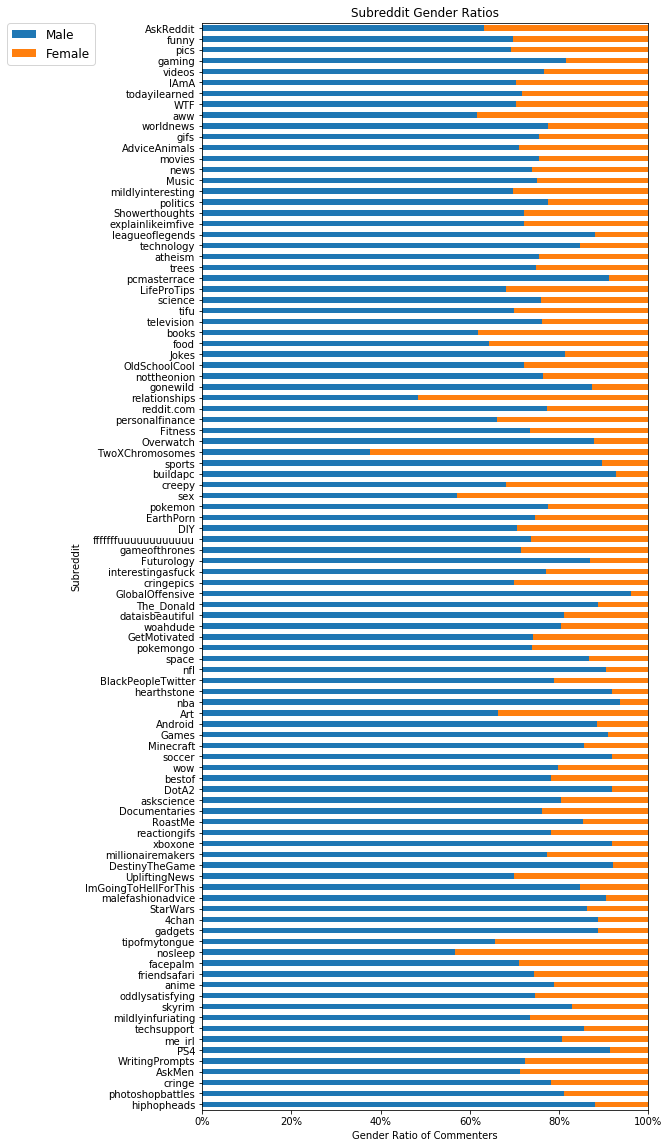

In [25]:
df.sort_values('subreddit_size', ascending=False, inplace=True)
plot = df[['male_ratio', 'female_ratio']].head(100)[::-1].plot(
    kind='barh',
    stacked=True,
    figsize=(8, 20),
    xlim=[0, 1],
    title='Subreddit Gender Ratios',
    legend=True,
)
plot.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
plot.set_ylabel('Subreddit')
plot.set_xlabel('Gender Ratio of Commenters')
plot.legend(loc='upper left', bbox_to_anchor=(-0.45, 1.005), fontsize=12)
plot.get_legend().get_texts()[0].set_text('Male')
plot.get_legend().get_texts()[1].set_text('Female')

Plot the gender ratio for the subreddits that are predominantly female. Only include subreddits that we have sampled at least 1000 users.

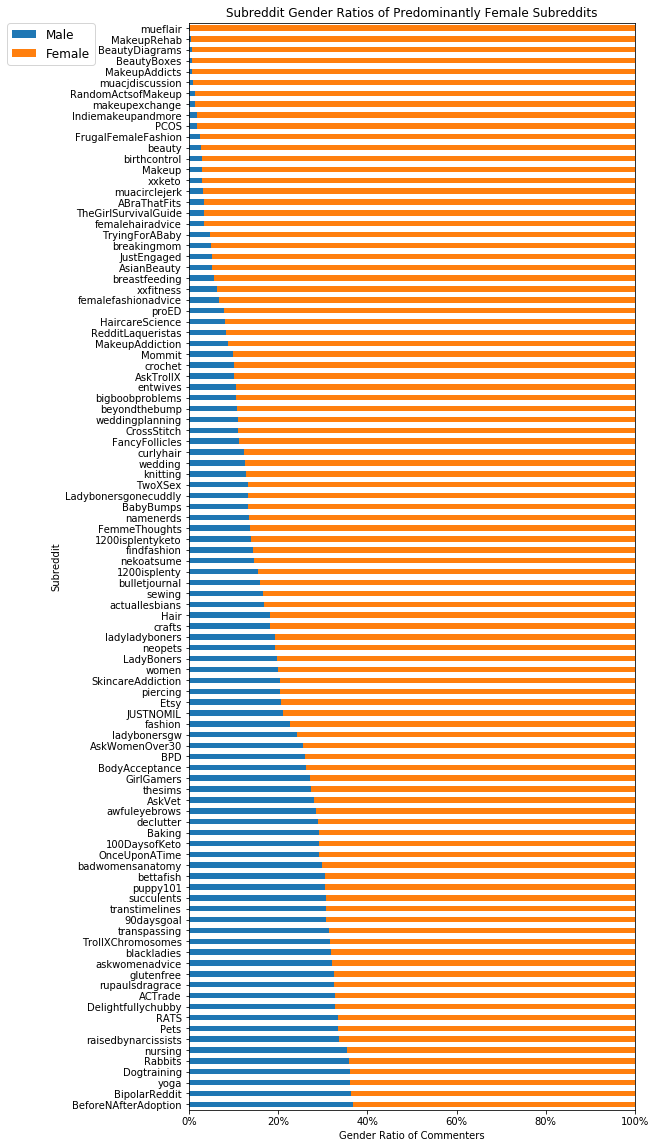

In [41]:
df_female = df[(df.male + df.female) > 1000][['male_ratio', 'female_ratio']]
plot = df_female.sort_values('female_ratio', ascending=False).head(100)[::-1].plot(
    kind='barh',
    stacked=True,
    figsize=(8, 20),
    xlim=[0, 1],
    title='Subreddit Gender Ratios of Predominantly Female Subreddits',
    legend=True,
)
plot.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
plot.set_ylabel('Subreddit')
plot.set_xlabel('Gender Ratio of Commenters')
plot.legend(loc='upper left', bbox_to_anchor=(-0.42, 1.005), fontsize=12)
plot.get_legend().get_texts()[0].set_text('Male')
plot.get_legend().get_texts()[1].set_text('Female')

Plot the gender ratio for the subreddits that are predominantly male. Only include subreddits that we have sampled at least 1000 users.

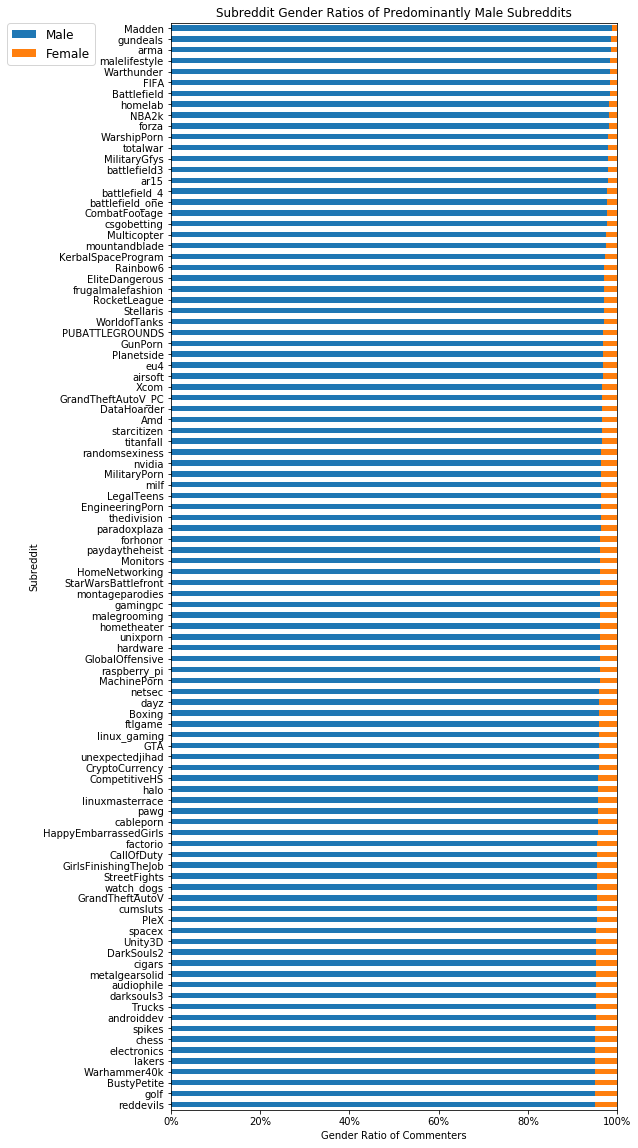

In [37]:
df_male = df[(df.male + df.female) > 1000][['male_ratio', 'female_ratio']]
plot = df_male.sort_values('male_ratio', ascending=False).head(100)[::-1].plot(
    kind='barh',
    stacked=True,
    figsize=(8, 20),
    xlim=[0, 1],
    title='Subreddit Gender Ratios of Predominantly Male Subreddits',
    legend=True,
)
plot.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
plot.set_ylabel('Subreddit')
plot.set_xlabel('Gender Ratio of Commenters')
plot.legend(loc='upper left', bbox_to_anchor=(-0.38, 1.005), fontsize=12)
plot.get_legend().get_texts()[0].set_text('Male')
plot.get_legend().get_texts()[1].set_text('Female')

Plot the total number of submitters and the number of users we actually sampled for each subreddit. Note that the number of male and female users barely even visible on the graph.

Or data is somewhat terrible. This is okay if our sampled users are somehow actually a perfect random sample. That isn't especially likely though.

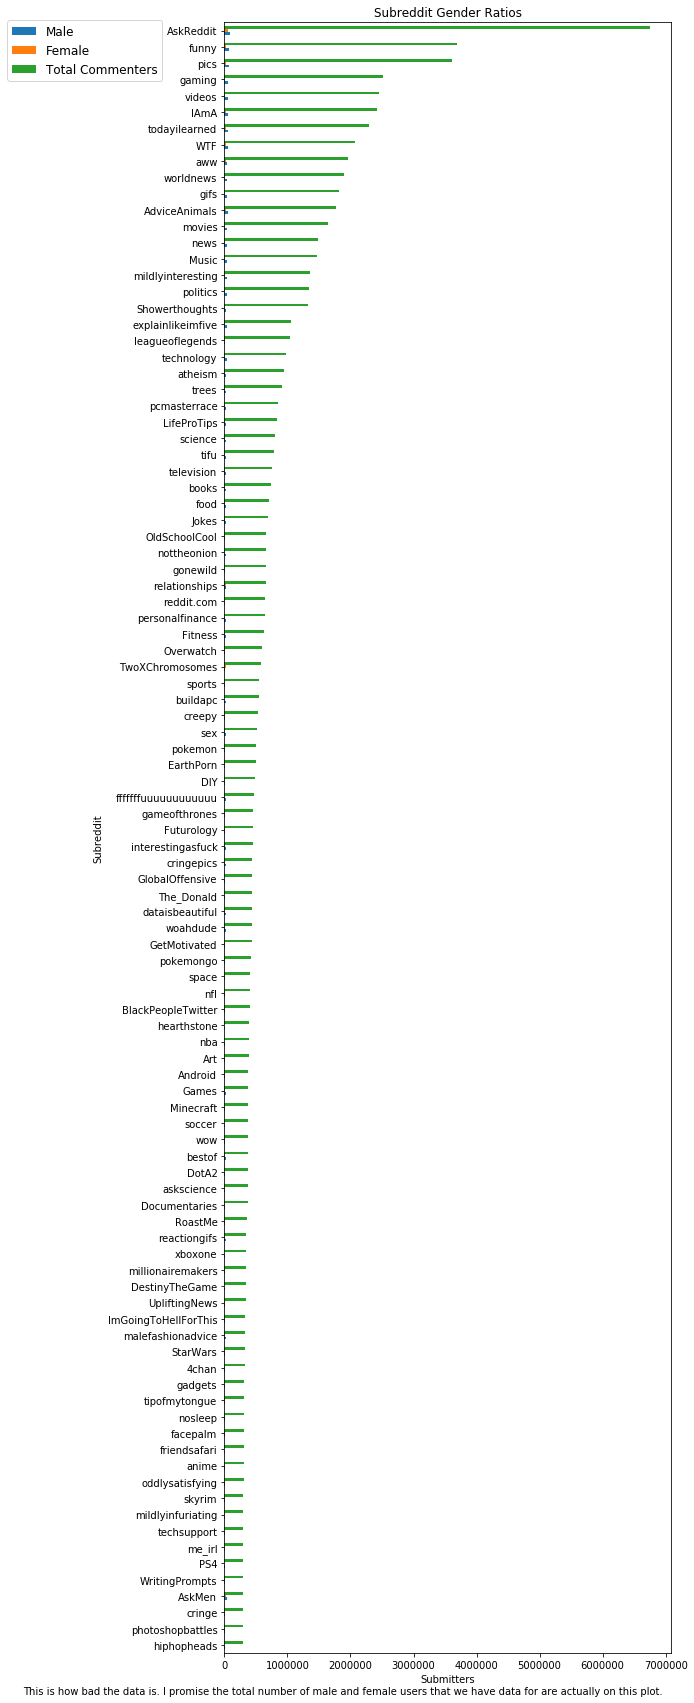

In [43]:
df.sort_values('subreddit_size', ascending=False, inplace=True)
plot = df[['male', 'female', 'subreddit_size']].head(100)[::-1].plot(
    kind='barh',
    figsize=(8, 30),
    title='Subreddit Gender Ratios',
    legend=True,
)
plot.set_ylabel('Subreddit')
plot.set_xlabel('Submitters')
plot.get_xaxis().get_major_formatter().set_scientific(False)
plot.legend(loc='upper left', bbox_to_anchor=(-0.5, 1.005), fontsize=12)
plot.text(-0.45, -0.02, 'This is how bad the data is. I promise the total number of male and female users that we have data for are actually on this plot.', fontsize=10,
          horizontalalignment='left',
          verticalalignment='top',
          transform=plot.axes.transAxes)
plot.get_legend().get_texts()[0].set_text('Male')
plot.get_legend().get_texts()[1].set_text('Female')
plot.get_legend().get_texts()[2].set_text('Total Commenters')

## Interactive chart

Now let's save the data to a CSV file so we can create an interactive chart using [D3.js][d3js].

[d3js]: https://d3js.org/

In [26]:
df[(df.female + df.male)>100].sort_values('subreddit_size', ascending=False).to_csv('subreddit_genders.csv')